<a href="https://colab.research.google.com/github/guidenis93/A-Student-Guide-to-Bayesian-Statistics/blob/main/Problem_set_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Random Walk Metropolis

Ce notebook ne correspond pas à un exercice dans le livre, mais plutôt à une application de l'agorithme pour estimer la distribution postérieure. Le notebook est basé sur: 

https://github.com/fonnesbeck/mcmc_pydata_london_2019/blob/master/notebooks/2-Markov_chain_Monte_Carlo.ipynb

In [ ]:
import numpy as np
import pandas as pd
import plotnine
import matplotlib.pyplot as plt
from plotnine import *
plotnine.options.figure_size = (8.4, 4.8)
from scipy.stats import norm, gamma, halfcauchy
import statsmodels.api as sm

In [ ]:
age = [13, 14, 14,12, 9, 15, 10, 14, 9, 14, 13, 12, 9, 10, 15, 11, 
                15, 11, 7, 13, 13, 10, 9, 6, 11, 15, 13, 10, 9, 9, 15, 14, 
                14, 10, 14, 11, 13, 14, 10]

price = [2950, 2300, 3900, 2800, 5000, 2999, 3950, 2995, 4500, 2800, 
                  1990, 3500, 5100, 3900, 2900, 4950, 2000, 3400, 8999, 4000, 
                  2950, 3250, 3950, 4600, 4500, 1600, 3900, 4200, 6500, 3500, 
                  2999, 2600, 3250, 2500, 2400, 3990, 4600, 450,4700]

data = {"age": age, "price": price}

df = pd.DataFrame(data) 

print(df.shape, "\n")

df.head()

(39, 2) 



,age,price
0,13,2950
1,14,2300
2,14,3900
3,12,2800
4,9,5000


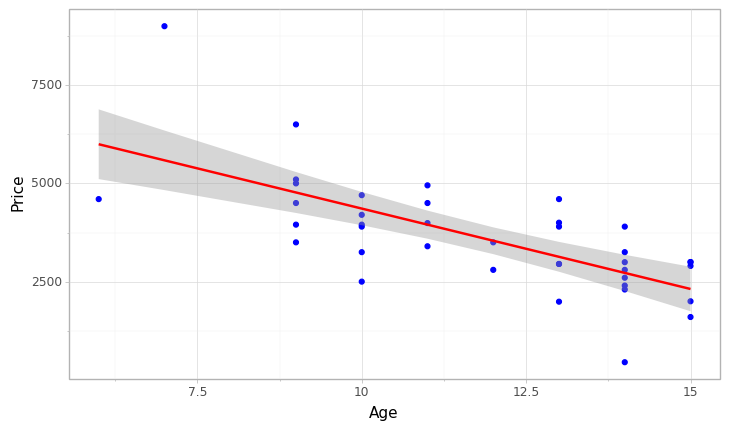

<ggplot: (8761773726497)>

In [ ]:
# Graphique
(ggplot(df, aes(x = "age", y = "price")) +
 geom_point(colour = "blue") +
 theme_light() +
 geom_smooth(method = "lm", colour = "red") +
 labs(x = "Age", y = "Price"))


## Frequentist OLS

In [ ]:
X = exog=df["age"]
X = sm.add_constant(X)
y = df["price"]

mod = sm.OLS(y, X)

res = mod.fit()

print(res.summary())

np.std(res.resid)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.468
Method:                 Least Squares   F-statistic:                     34.38
Date:                Thu, 13 May 2021   Prob (F-statistic):           9.62e-07
Time:                        00:20:51   Log-Likelihood:                -325.45
No. Observations:                  39   AIC:                             654.9
Df Residuals:                      37   BIC:                             658.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8451.5909    840.054     10.061      0.0

1018.2524542413332

## Bayesian OLS

In [ ]:
def eval_posterior(params):
  
  # Current parameters
  alpha = params[0]
  beta = params[1]
  sigma = params[2]

  # Log probability priors alpha, beta
  logp = norm.logpdf(alpha, 0, 10) + norm.logpdf(beta, 0, 10)

  # Log probability prior sigma
  logp += gamma.logpdf(sigma, 0.0001, 0.001)
  
  # Compute loglikehood
  for x, y in zip(df["age"], df["price"]/1000):
    mu = alpha + beta*x
  
    logp += norm.logpdf(y, mu, sigma**-0.5)

  return logp

In [ ]:
def Metropolis(n_iterations, initial_values, prop_var, tune_interval = 100):

  # Number of parameters
  num_params = len(initial_values)

  # Logprobability for initial values
  current_logp = eval_posterior(initial_values)

  trace = initial_values
  trace_dic = {0: [], 1: [], 2: []}
  accept_dic = {0: 0, 1: 0, 2: 0}
  
  for i in range(n_iterations):
    
    if ((i+1) % 500) == 0: 
      print(f"Iteration: {i + 1}")

    for j in range(num_params):

      current_params = trace.copy()

      # Propose new parameter
      if j == 2:
        # Ensure sigma is positive
        theta = np.exp(np.random.normal(np.log(current_params[j]), prop_var[j]))
      else:
        theta = np.random.normal(current_params[j], prop_var[j])

      # Insert new value
      current_params[j] = theta

      # Compute log probability with new parameters
      new_logp = eval_posterior(current_params)

      # Calculate acceptance-rate
      if new_logp >= current_logp:
        alpha = 1
      else:
        alpha = new_logp - current_logp
      
      # Generate ratio from uniform distribution
      r = np.random.rand()

      if alpha >= np.log(r):
        # Accept
        trace = current_params
        trace_dic[j].append(theta)
        accept_dic[j] +=1
        current_logp = new_logp
         
      # print(new_logp, current_logp)
      # print(prop_var, "\n")

      # Adjust variance every tune_interval
      if ((i+1) % tune_interval) == 0:
        accept_ratio = accept_dic[j] / tune_interval
        # print(accept_dic[j])
        

        if accept_ratio < 0.2:
          prop_var[j] *= 0.9
        
        elif accept_ratio > 0.4:
          prop_var[j] *= 1.1

        # Put counter to zero
        accept_dic[j] = 0

      
  return trace_dic

In [ ]:
np.random.seed(101)
a = Metropolis(10000, [10, 0, 1], prop_var = [1, 1, 1])

Iteration: 500
Iteration: 1000
Iteration: 1500
Iteration: 2000
Iteration: 2500
Iteration: 3000
Iteration: 3500
Iteration: 4000
Iteration: 4500
Iteration: 5000
Iteration: 5500
Iteration: 6000
Iteration: 6500
Iteration: 7000
Iteration: 7500
Iteration: 8000
Iteration: 8500
Iteration: 9000
Iteration: 9500
Iteration: 10000


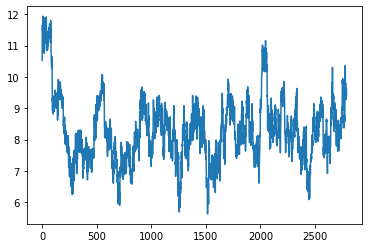

In [ ]:
plt.plot(a[0])

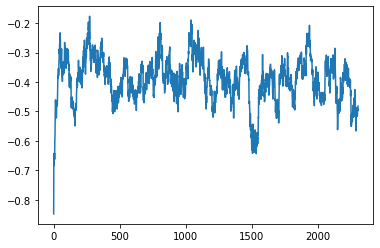

In [ ]:
plt.plot(a[1])

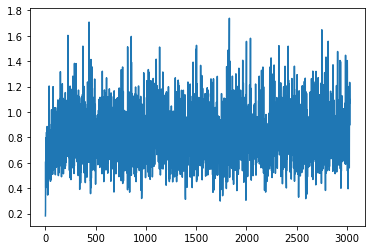

In [ ]:
plt.plot(a[2])